In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd
import iminuit
from iminuit import Minuit

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

#### Helper functions

In [3]:
# Peak finding function from Lars
from scipy import signal
def func_find_peaks(y, required_dist, required_prominence):  # height, required_dist):
    """identifies peaks, input : 
        - y = an array that contains the signal - the flux/intensity etc; 
        - required_dist = minimum distance between peaks
        - required_prominence = minimum prominence of peaks
        
        returns peak index, prominences, left and right indexes - for widths and the actual width
        [0] peak index in initial array, [1] prominences, [2] left index for widths, [3] right index for widths ,
        [4] length of the width, [5] peak height 0 reference """

    peaks, dict_peak = signal.find_peaks(x=y, distance=required_dist, height=np.zeros(len(y)), prominence=required_prominence)  # height=height,
    prom = signal.peak_prominences(x=y, peaks=peaks, wlen=20)
    widths = signal.peak_widths(x=y, peaks=peaks, rel_height=1, prominence_data=prom)
    return peaks, prom[0], np.round(widths[2]).astype(int), np.round(widths[3]).astype(int), widths[0], dict_peak['peak_heights']


def get_peak_index_ranges(peak_locs):
    """ Returns an array of indexes (start, end) of a range around each peak. """
    
    # First compute desired peak_range_size: the mean separation between peaks
    peak_range_size = int(np.mean(np.diff(peak_locs)))
    
    peak_index_ranges = []
    for nPeak in peak_locs:
        start = nPeak - peak_range_size/2
        end = nPeak + peak_range_size/2
        peak_index_ranges.append([int(start), int(end)])
    return np.asarray(peak_index_ranges)


def fit_peaks(data_spec, data_spec_err, peak_index_ranges, print=False):
    """ Returns array of the fit values with errors: A, A_err, mu, mu_err, sigma, sigma_err, C, C_err, chi2_val, ndof, converged (bool) """

    peak_fits = []
    for peak_index_range in peak_index_ranges:

        index_start, index_end = peak_index_range

        x = np.arange(index_start, index_end) # range from the start of the peak index to the end of the peak index (index ~ nPix)
        y = np.array(data_spec[index_start:index_end])
        ey = np.array(data_spec_err[index_start:index_end])

        # Fitting functions:
        def func_GaussConst(x, A, mu, sigma, C) :
            return A * np.exp(-0.5 * ((x-mu)/sigma)**2)  +  C
            # return A * stats.norm.pdf(x, mu, sigma) + C       # doesn't seem to work  ... 


        # ChiSquare fit model:
        def model_chi2(A, mu, sigma, C) :
            y_fit = func_GaussConst(x, A, mu, sigma, C)
            chi2 = np.sum(((y - y_fit) / ey)**2)
            return chi2
        model_chi2.errordef = 1

        # Fit peak with a Gaussian:
        A_init     = 0.45
        mu_init    = np.mean(x)
        sigma_init = -1.6
        C_init     = 0.02
        minuit = Minuit(model_chi2, A=A_init, mu=mu_init, sigma=sigma_init, C=C_init)

        # Perform the actual fit (and save the parameters):
        minuit.migrad()                                             
        
        # Extract the fitting parameters and their uncertainties:
        Npoints = len(x)
        ndof = Npoints - len(minuit.values[:])
        Chi2_val = minuit.fval # The chi2 value
        converged = minuit.fmin.is_valid

        # peak_fits.append([*minuit.values, Chi2_val])
        peak_fits.append([
            minuit.values['A'],
            minuit.errors['A'],
            minuit.values['mu'],
            minuit.errors['mu'],
            minuit.values['sigma'],
            minuit.errors['sigma'],
            minuit.values['C'],
            minuit.errors['C'],
            Chi2_val,
            ndof,
            converged,
            index_start, 
            index_end
        ])
        
        if print:
            print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_val:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")

    return np.asarray(peak_fits)

#### Demonstration of the peak shape

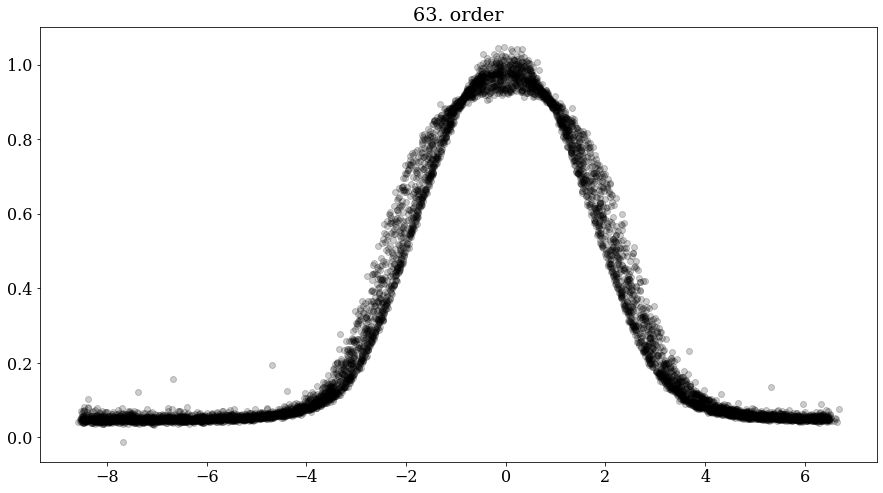

In [6]:
def do_the_thing(order, figsize=(15,8)):

    # Import data
    # filename = r"expres_tp/LFC_200907.1063.fits"
    filename = "/Users/jakobharteg/kDrive/Uni/Kurser/Bachelorprojekt/Data/EXPRES_spectra/LFC/LFC_210103.1112.fits"
    hdu1 = fits.open(filename)
    data = hdu1[1].data.copy()
    data_spec       = data['spectrum'][order]
    data_spec_err   = data['uncertainty'][order]

    # Find peaks
    peak_info = func_find_peaks(data_spec, 11, 0.15)
    peak_locs = peak_info[0]

    # Create data slices around each peak
    peak_index_ranges = get_peak_index_ranges(peak_locs)

    # Fit peak in each data slice
    peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)
    fit_means = peak_fits[:, 2]
    fit_amps = peak_fits[:, 0]

    plt.figure(figsize=figsize)

    for peak_n in range(0, len(peak_locs)):
        
        # X values:
        xmin, xmax = peak_index_ranges[peak_n]
        xrange = np.arange(xmin, xmax)
        
        # Y values:
        peak_data = data_spec[xrange]
        peak_data = peak_data / fit_amps[peak_n] # rescale peak height 
        
        # Shift/center peaks (X-values) around the mean from previous fit
        xrange = xrange - fit_means[peak_n] 
        
        plt.title(f"{order}. order")
        plt.plot(xrange, peak_data, "o", color="k", alpha=0.2)


# You can change the order and see that it happens for all
do_the_thing(order = 63)

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_19029/353638116.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


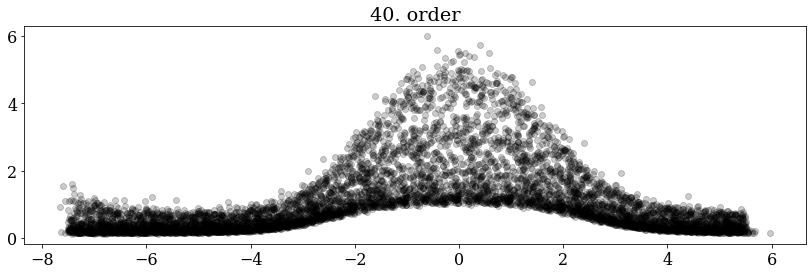

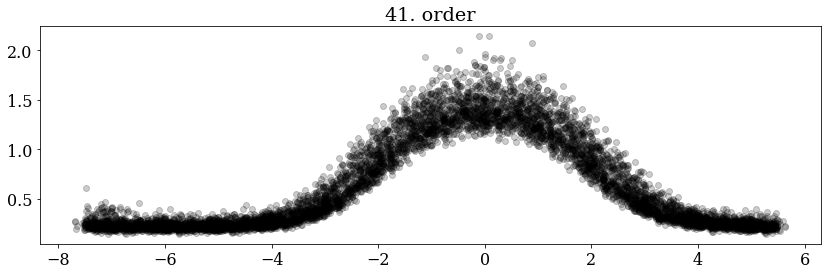

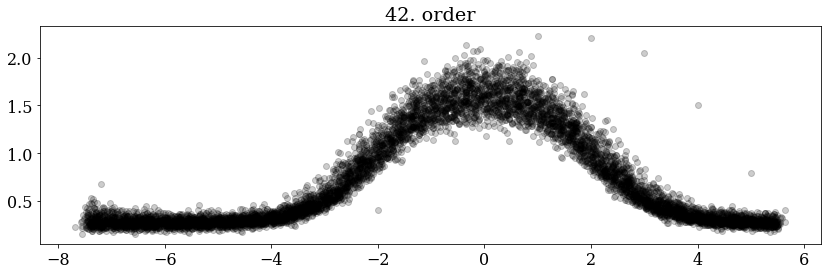

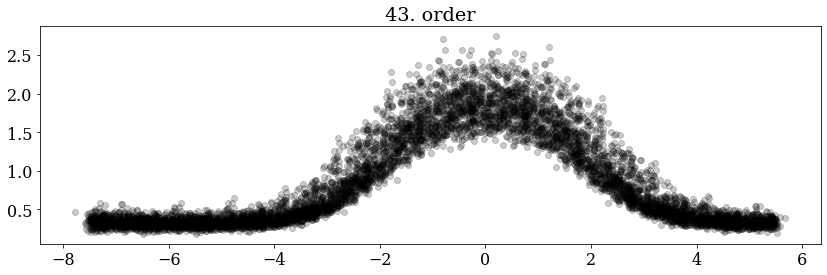

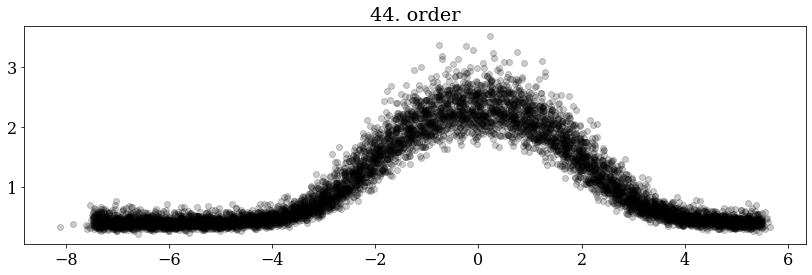

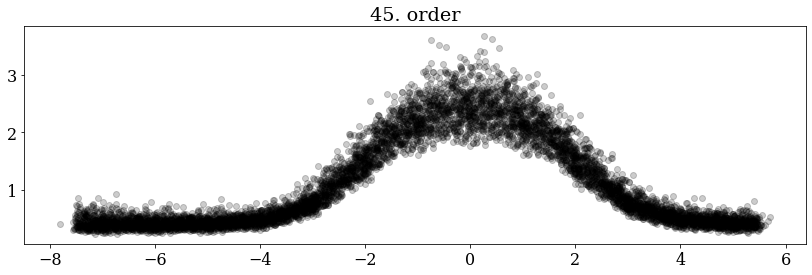

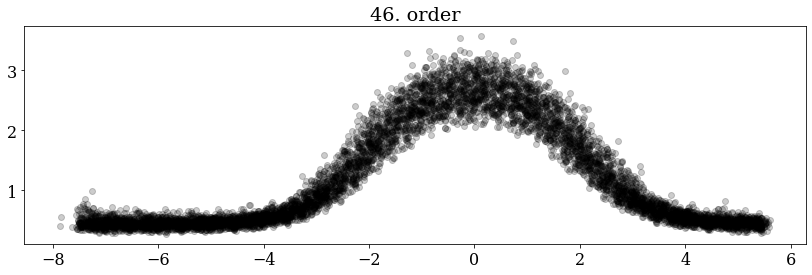

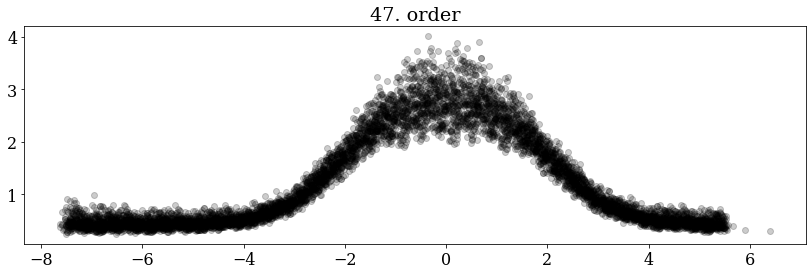

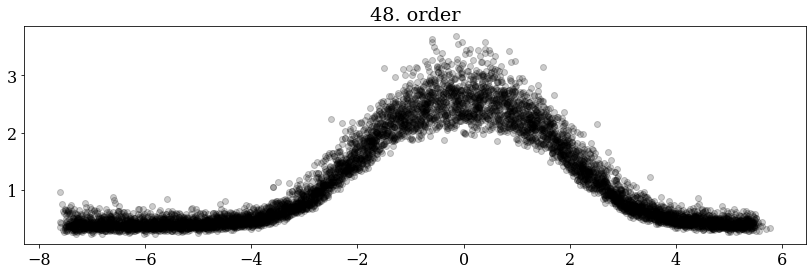

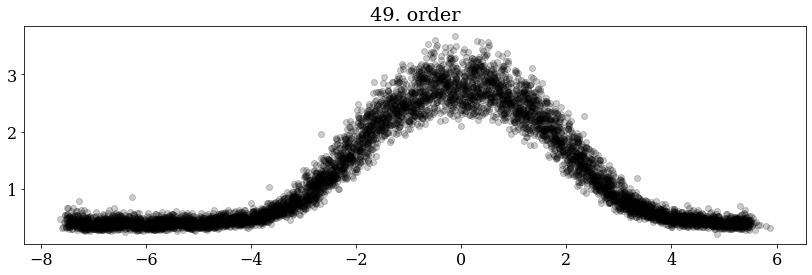

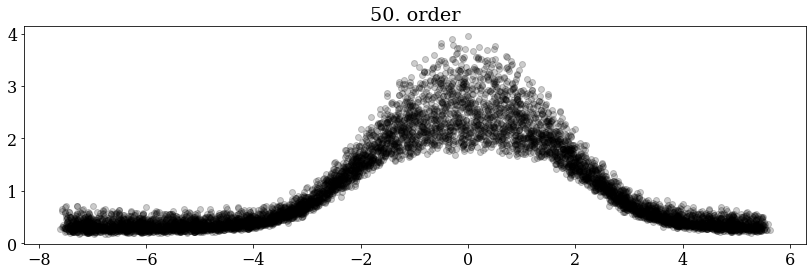

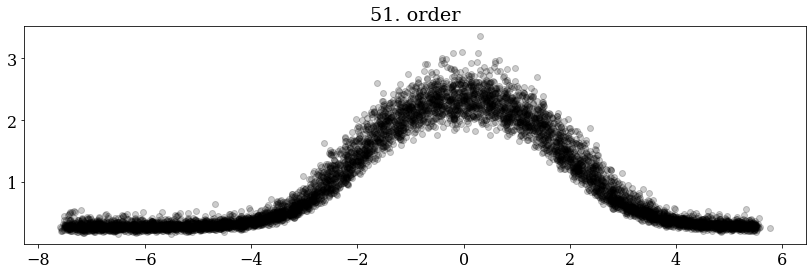

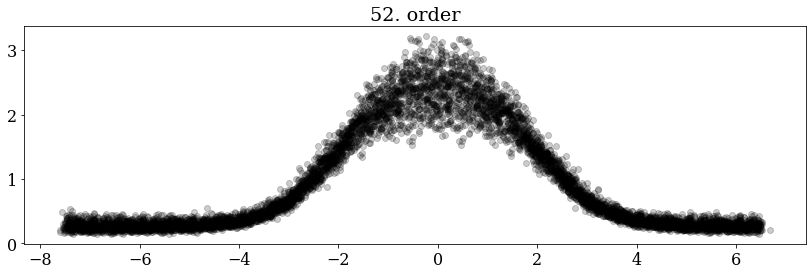

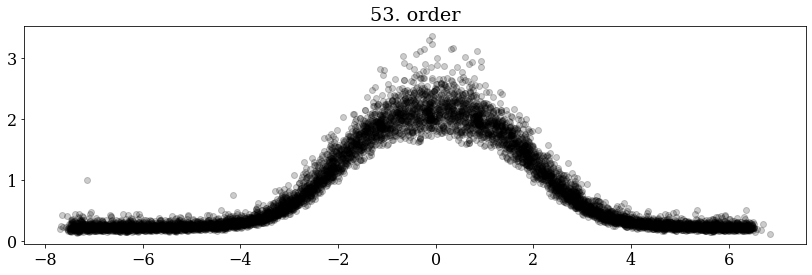

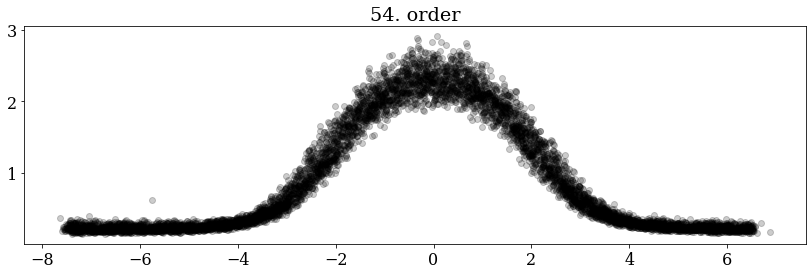

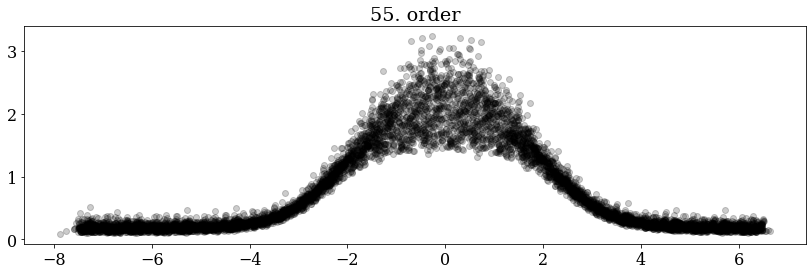

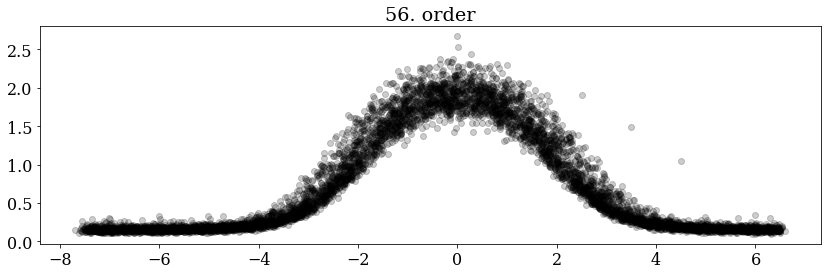

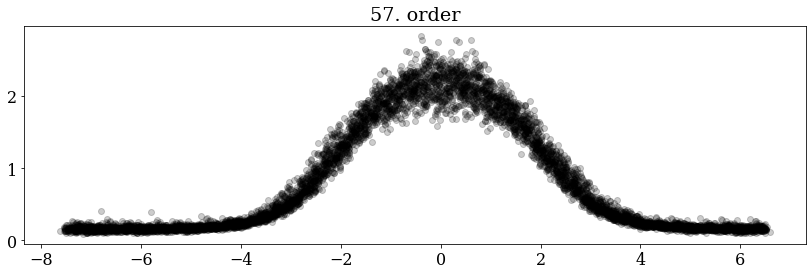

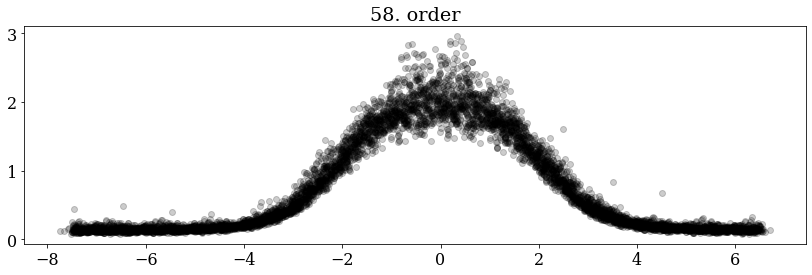

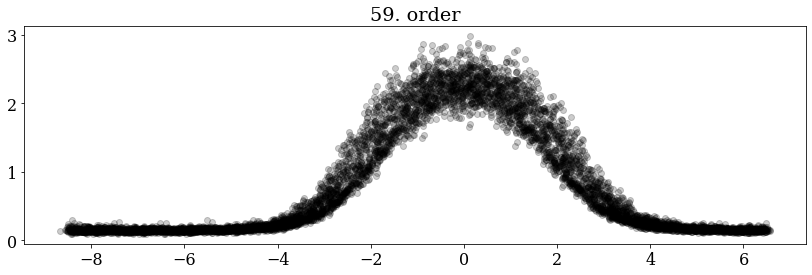

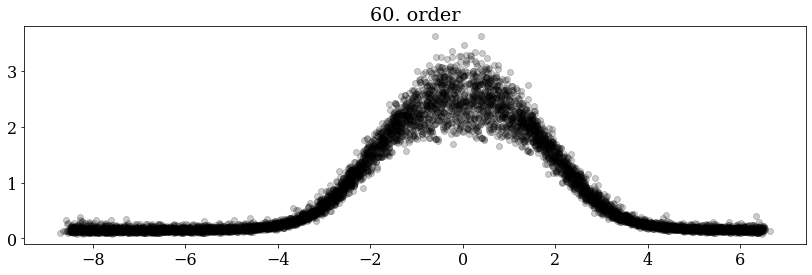

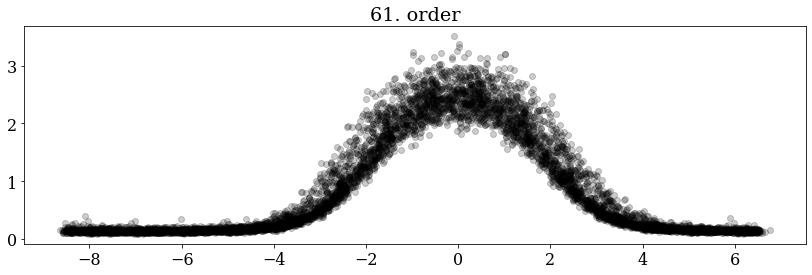

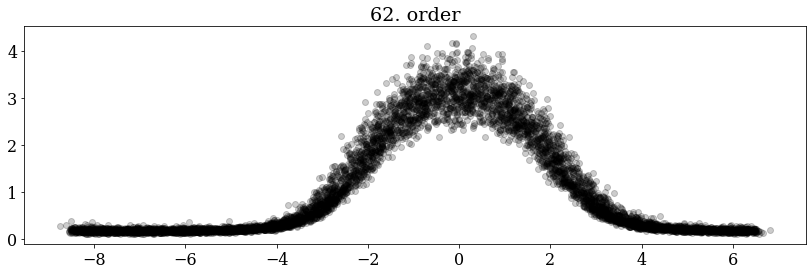

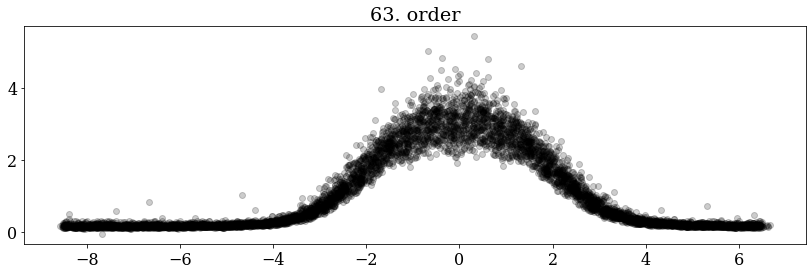

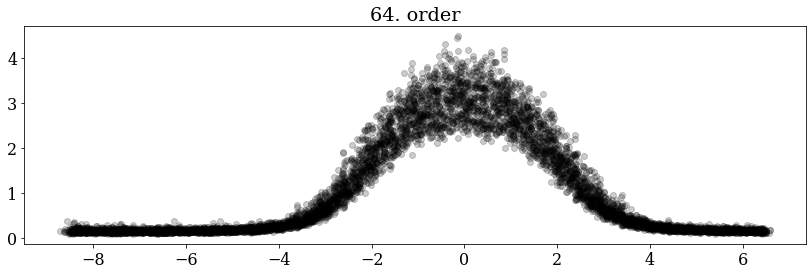

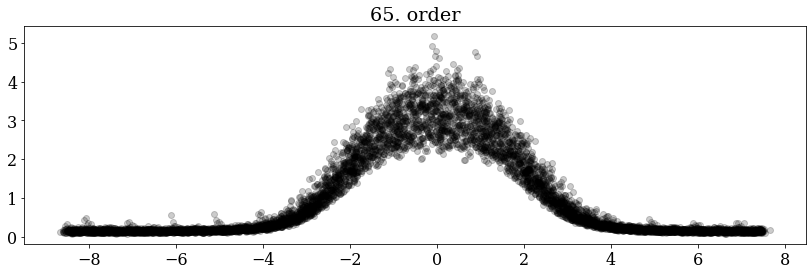

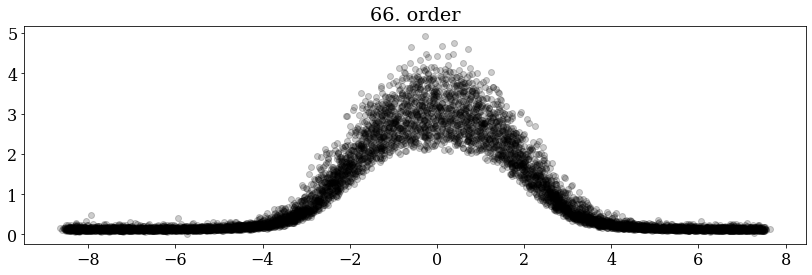

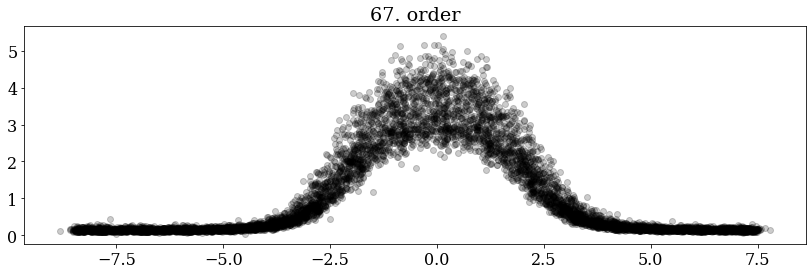

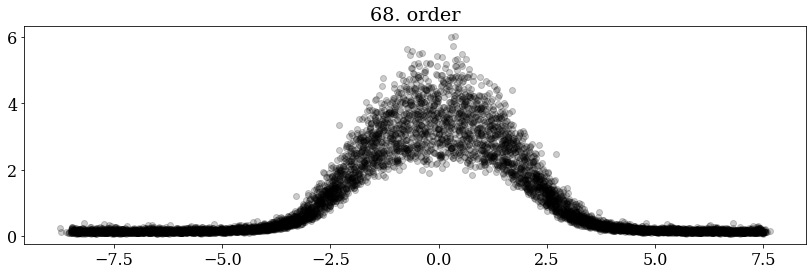

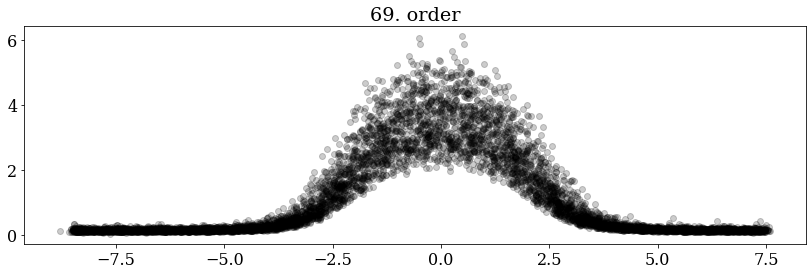

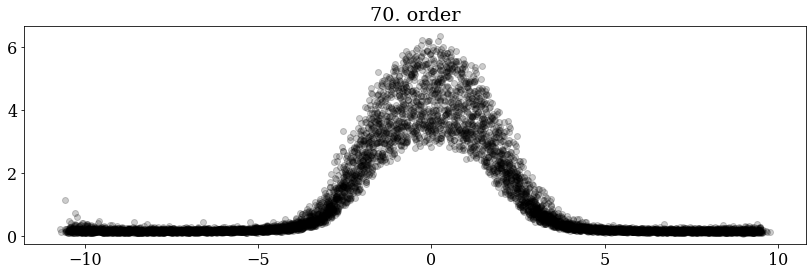

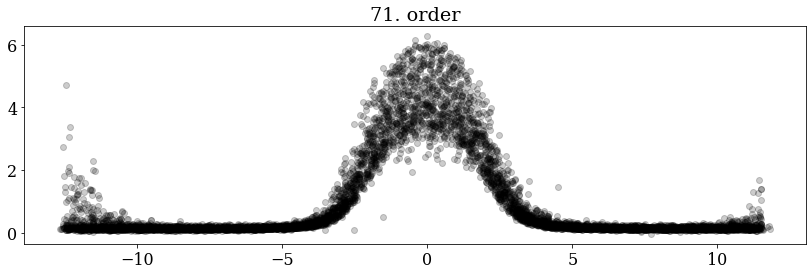

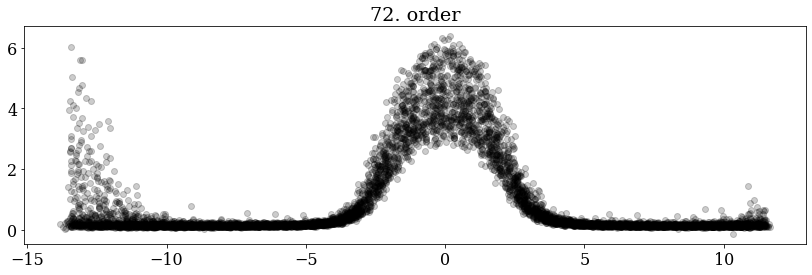

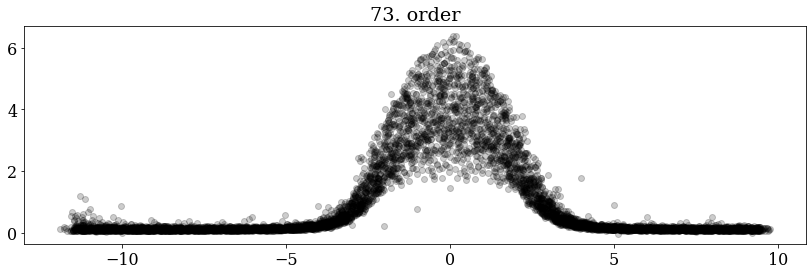

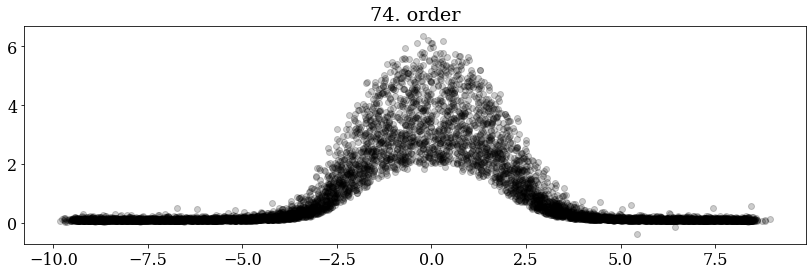

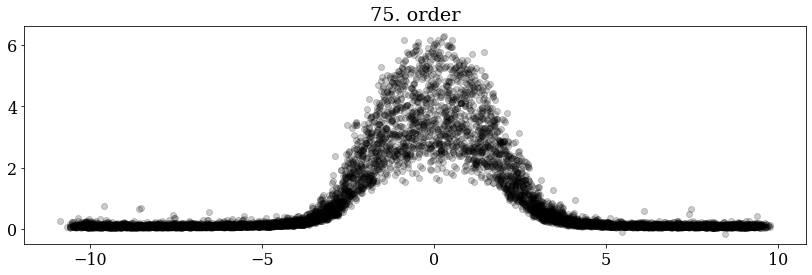

In [5]:
for order in np.arange(40, 76):
    do_the_thing(order, figsize=(14, 4))